In [2]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/actigraphydata/CleanedActigraphyData.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the training data
train = pd.read_csv(base_path)
train.head(5)

,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [3]:
# Drop rows with specific participant IDs
train = train[~train['participant_id'].isin(['ab16a20d', 'db38d1f9'])]

# Check the dataset after removing the rows
train.head()


,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [4]:
# Drop the 'activity_level' column as it was introduced to understand the data
train = train.drop(columns=['activity_level','participant_id'])

In [5]:
train.head()

,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,sii
0,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,1.0
1,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,1.0
2,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,1.0
3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,0.0
4,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,0.0


Feature Variances:
 mean_enmo                  0.000599
std_enmo                   0.003330
max_enmo                   3.626496
min_enmo                   0.000030
mean_magnitude             0.001824
std_magnitude              0.003275
inactivity_percentage    214.378179
non_wear_percentage      746.930445
dtype: float64


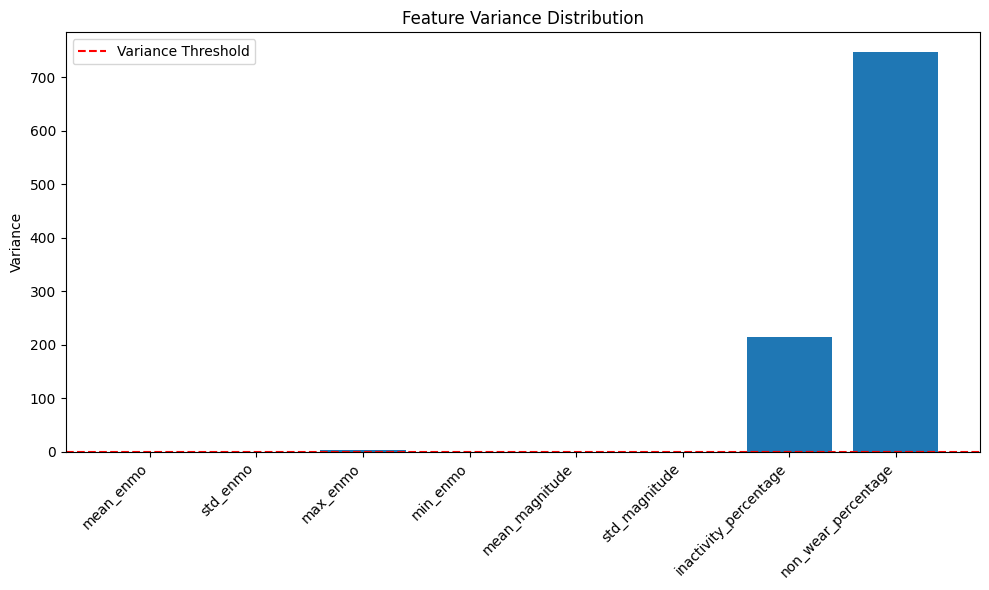

Classification Report (No Resampling):
              precision    recall  f1-score   support

         0.0       0.65      0.47      0.55       175
         1.0       0.30      0.15      0.20        80
         2.0       0.15      0.12      0.13        41
         3.0       0.00      0.00      0.00         3

    accuracy                           0.33       299
   macro avg       0.28      0.19      0.22       299
weighted avg       0.48      0.33      0.39       299

Classification Report (With Resampling):
              precision    recall  f1-score   support

         0.0       0.68      0.39      0.50       175
         1.0       0.23      0.11      0.15        80
         2.0       0.14      0.24      0.18        41
         3.0       0.00      0.00      0.00         3

    accuracy                           0.29       299
   macro avg       0.26      0.19      0.21       299
weighted avg       0.47      0.29      0.36       299

Confusion Matrix (No Resampling):
[[83 18 18 56]
 

In [7]:
X = train.drop(columns=['sii'])
y = train['sii']

# Initial Feature Variance Analysis
feature_variances = np.var(X, axis=0)
print("Feature Variances:\n", feature_variances)

selected_features = feature_variances.index
X_high_variance = X[selected_features]

# Plotting Feature Variances
plt.figure(figsize=(10, 6))
plt.bar(feature_variances.index, feature_variances.values)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label="Variance Threshold")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Distribution")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)

# PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_2d, y, test_size=0.3, random_state=42, stratify=y
)


# Model without resampling
svm_model_no_resample = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model_no_resample.fit(X_train, y_train)
y_pred_no_resample = svm_model_no_resample.predict(X_test)

# Model with SMOTE-Tomek resampling
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
svm_model_with_resample = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model_with_resample.fit(X_resampled, y_resampled)
y_pred_with_resample = svm_model_with_resample.predict(X_test)

# Step 9: Evaluate the models (e.g., using classification report and confusion matrix)
print("Classification Report (No Resampling):")
print(classification_report(y_test, y_pred_no_resample))

print("Classification Report (With Resampling):")
print(classification_report(y_test, y_pred_with_resample))

# Optional: Confusion Matrix
print("Confusion Matrix (No Resampling):")
print(confusion_matrix(y_test, y_pred_no_resample))

print("Confusion Matrix (With Resampling):")
print(confusion_matrix(y_test, y_pred_with_resample))


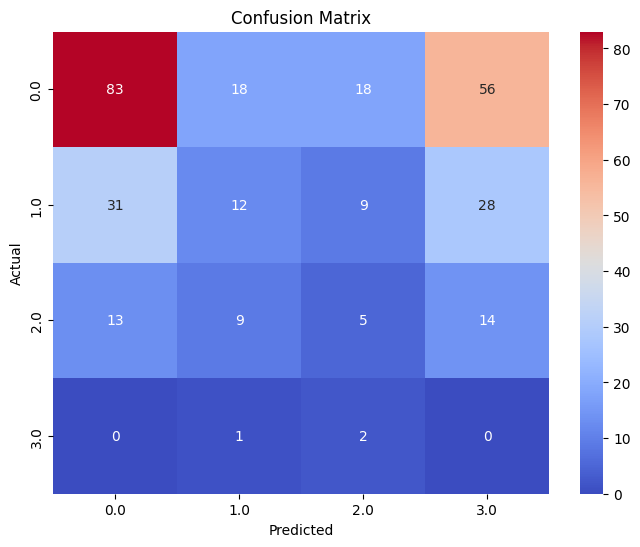

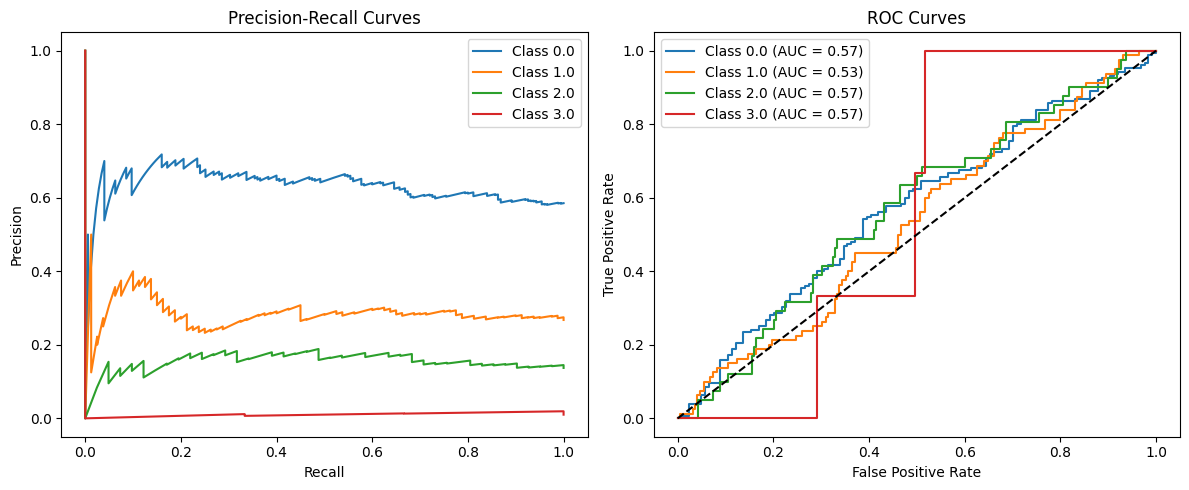

In [8]:
# non-resampled model is the better choice
final_model = svm_model_no_resample
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, fmt='d', cmap="coolwarm", 
    xticklabels=np.unique(y), 
    yticklabels=np.unique(y)
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and Precision-Recall Curves
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

plt.figure(figsize=(12, 5))

# Precision-Recall Curves
plt.subplot(121)
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# ROC Curves
plt.subplot(122)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()



In [12]:
# Combine original X_test with PCA features and y_test into a single DataFrame

# Convert original X_test (before PCA) into a DataFrame
X_test_original = pd.DataFrame(X_test, columns=X.columns)  # Using original feature names from X

# Convert PCA features (X_pca_2d) into a DataFrame
# X_test_pca = pd.DataFrame(X_pca_2d, columns=[f"PC{i+1}" for i in range(X_pca_2d.shape[1])])

# Combine original features, PCA features, and target variable
test_data_combined = pd.concat([X_test_original, y_test.reset_index(drop=True)], axis=1)
test_data_combined.rename(columns={'sii': 'target'}, inplace=True)

# Save the combined DataFrame to CSV
test_data_combined_path = '/kaggle/working/actigraphy_test_data_combined.csv'
test_data_combined.to_csv(test_data_combined_path, index=False)

print("Test data (original + PCA + target) saved successfully.")


ValueError: Shape of passed values is (299, 2), indices imply (299, 8)

In [ ]:
import joblib
model_path = '/kaggle/working/svm_actigraphydata_model.pkl'
joblib.dump(final_model, model_path)

# Save scaler and PCA (for later use in test dataset prediction)
scaler_path = '/kaggle/working/svm_actigraphydata_scaler.pkl'
pca_path = '/kaggle/working/svm_actigraphydata_pca.pkl'
joblib.dump(scaler, scaler_path)
joblib.dump(pca_2d, pca_path)



# Step 12: Save Predictions (Optional)
predictions_df = pd.DataFrame({
    'Predicted_Label': y_pred
})

predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

print("Model, scaler, PCA, and predictions saved successfully.")